# Sleep Efficiency — ML Final Project (Single Notebook)

Notebook único com tudo: carregamento de dados, engenharia de features, treino com GroupKFold, verificação contra vazamento (shuffle), treino final, métricas (AUC/Precision/Recall/F1), seleção de limiar e gráficos (ROC, PR e matriz de confusão).

In [ ]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import os
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")

DATA_PATH = Path('./data/sleep.csv')
REPORTS_DIR = Path('reports')
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print('Usando DATA_PATH =', DATA_PATH.resolve())

Usando DATA_PATH = /home/vini/dev/machine-learning-final-project/src/data/sleep.csv


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

def load_data(path: Path) -> pd.DataFrame:
    return pd.read_csv(path)

def make_target(df: pd.DataFrame) -> pd.Series:
    return (df["Sleep efficiency"] < 0.85).astype(int)

def _circ(ts):
    if pd.isna(ts):
        return (np.nan, np.nan)
    rad = (ts.hour + ts.minute / 60.0) / 24.0 * 2 * np.pi
    return (np.cos(rad), np.sin(rad))

def engineer(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # horários (codificação circular)
    bt = pd.to_datetime(df.get("Bedtime"), errors="coerce")
    wu = pd.to_datetime(df.get("Wakeup time"), errors="coerce")

    bt_cs = bt.apply(_circ).apply(pd.Series)
    wu_cs = wu.apply(_circ).apply(pd.Series)
    df["bt_cos"], df["bt_sin"] = bt_cs[0], bt_cs[1]
    df["wu_cos"], df["wu_sin"] = wu_cs[0], wu_cs[1]

    for col in ["Gender", "Smoking status"]:
        if col in df.columns:
            df[col] = df[col].astype("category")

    df = pd.get_dummies(
        df,
        columns=[c for c in ["Gender", "Smoking status"] if c in df.columns],
        drop_first=True,
    )

    keep = [
        "Caffeine intake", "Alcohol consumption", "Exercise frequency",
        "Age",
    ] + [c for c in df.columns if c.startswith("Gender_") or c.startswith("Smoking status_")]

    df = df.reindex(columns=keep)

    df.columns = df.columns.str.replace(r"\s+", "_", regex=True)
    df = df.loc[:, df.notna().any(axis=0)]  
    const = df.nunique(dropna=False) <= 1   
    df = df.loc[:, ~const]

    return df

def sanitize_features_targets(Xf: pd.DataFrame, y: pd.Series):
    Xf = Xf.copy()

    Xf.columns = Xf.columns.map(lambda c: str(c).strip().replace(" ", "_"))

    for col in Xf.columns:
        if not np.issubdtype(Xf[col].dtype, np.number):
            Xf[col] = pd.to_numeric(Xf[col], errors="coerce")

    Xf = Xf.loc[:, Xf.notna().any(axis=0)]
    const_mask = Xf.nunique(dropna=False) <= 1
    if const_mask.any():
        Xf = Xf.loc[:, ~const_mask]

    arr = Xf.to_numpy(dtype=float, copy=False)
    finite_mask = np.isfinite(arr).all(axis=1)
    Xf = Xf.loc[finite_mask]
    y = y.loc[Xf.index]

    Xf = Xf.dropna(axis=0)
    y = y.loc[Xf.index].astype(int)
    y.index = Xf.index

    return Xf, y


In [ ]:
def logistic_pipe():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500, solver="lbfgs"))
    ])

def gbm_pipe():
    clf = LGBMClassifier(
        n_estimators=100,
        learning_rate=0.05,
        num_leaves=31,
        min_child_samples=10,
        n_jobs=1,
        random_state=42,
    )
    return CalibratedClassifierCV(clf, method="sigmoid", cv=3, n_jobs=1)

def metrics(y_true, prob, thr=0.5):
    y_pred = (prob >= thr).astype(int)
    return {
        "auc": roc_auc_score(y_true, prob),
        "f1": f1_score(y_true, y_pred)
    }


In [ ]:
df = load_data(DATA_PATH)
Xf = engineer(df)
y = make_target(df)
Xf, y = sanitize_features_targets(Xf, y)

groups = df.get("Subject ID", pd.Series(np.arange(len(df), dtype=int), index=df.index))
groups = pd.Series(groups).loc[Xf.index]

gkf = GroupKFold(n_splits=max(2, min(5, int(pd.Series(groups).nunique()))))
candidates = [("log_reg", logistic_pipe), ("gbm", gbm_pipe)]

results = []
best_name, best_auc = None, -np.inf
best_builder = None
for name, builder in candidates:
    fold_scores = []
    for trn_idx, val_idx in gkf.split(Xf, y, groups):
        model = builder()
        X_tr, y_tr = Xf.iloc[trn_idx], y.iloc[trn_idx]
        X_va, y_va = Xf.iloc[val_idx], y.iloc[val_idx]
        model.fit(X_tr, y_tr)
        prob = model.predict_proba(X_va)[:, 1]
        fold_scores.append(metrics(y_va, prob))
    results.append((name, fold_scores))
    auc_mean = float(np.mean([s["auc"] for s in fold_scores]))
    if auc_mean > best_auc:
        best_auc = auc_mean
        best_name = name
        best_builder = builder

rng = np.random.default_rng(123)
y_shuf = pd.Series(rng.permutation(y.values), index=y.index)
results_shuf = []
for name, builder in candidates:
    fold_scores = []
    for trn_idx, val_idx in gkf.split(Xf, y_shuf, groups):
        model = builder()
        X_tr, y_tr = Xf.iloc[trn_idx], y_shuf.iloc[trn_idx]
        X_va, y_va = Xf.iloc[val_idx], y_shuf.iloc[val_idx]
        model.fit(X_tr, y_tr)
        prob = model.predict_proba(X_va)[:, 1]
        fold_scores.append(metrics(y_va, prob))
    results_shuf.append((name, fold_scores))

summary = {
    "best_model": best_name,
    "best_auc_cv": best_auc,
    "cv_details": results,
    "cv_details_shuffled_y": results_shuf,
    "n_rows_train": int(Xf.shape[0]),
    "n_cols_train": int(Xf.shape[1]),
    "n_groups": int(pd.Series(groups).nunique()),
}
print(json.dumps(summary, indent=2))

with open(REPORTS_DIR/"train_debug.json", "w") as f:
    json.dump(summary, f, indent=2)

[LightGBM] [Info] Number of positive: 125, number of negative: 105
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 230, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543478 -> initscore=0.174353
[LightGBM] [Info] Start training from score 0.174353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Info] Number of positive: 159, number of negative: 129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552083 -> initscore=0.209092
[LightGBM] [Info] Start training from score 0.209092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

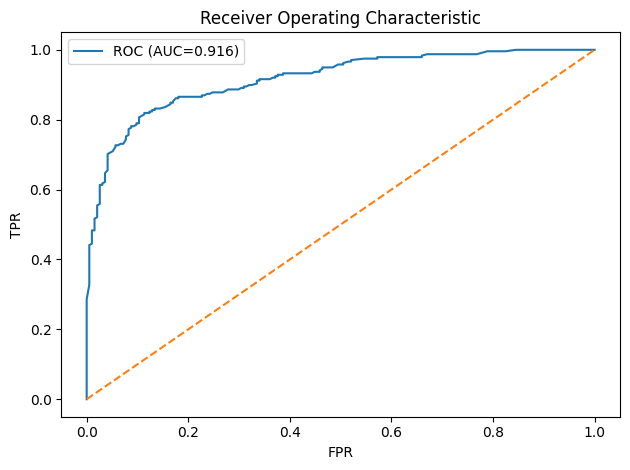

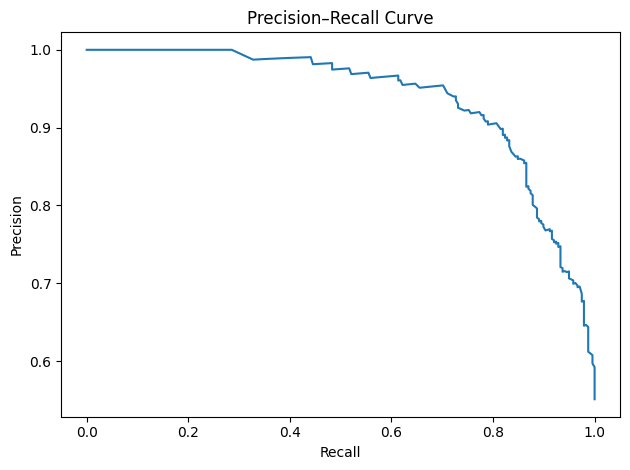

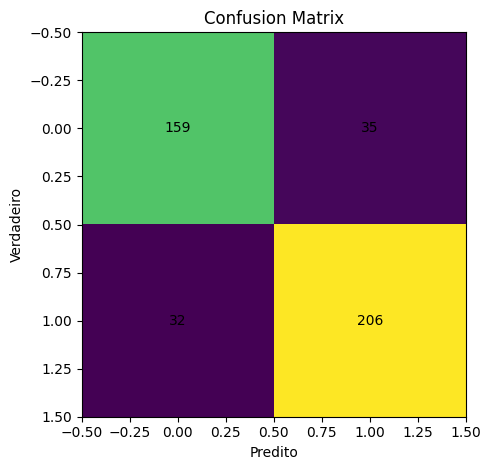

{
  "threshold": 0.5048434390478295,
  "auc": 0.916312916919345,
  "precision": 0.8547717842323651,
  "recall": 0.865546218487395,
  "f1": 0.860125260960334,
  "support_pos": 238,
  "n_samples": 432,
  "plots": {
    "roc": "reports/holdin_roc.png",
    "pr": "reports/holdin_pr.png",
    "cm": "reports/holdin_cm.png"
  }
}


In [ ]:
assert best_builder is not None
final_model = best_builder()
final_model.fit(Xf, y)

prob_all = final_model.predict_proba(Xf)[:,1]

prec, rec, thr = precision_recall_curve(y, prob_all)
f1s = 2*(prec*rec)/(prec+rec + 1e-12)
best_idx = int(np.nanargmax(f1s))
best_thr = 0.5 if best_idx == len(thr) else float(thr[best_idx])
print('Limiar escolhido (F1-max):', best_thr)

def plot_and_save_curves(y_true, prob, thr, prefix: str):
    fpr, tpr, _ = roc_curve(y_true, prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc_score(y_true, prob):.3f})')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.tight_layout()
    p1 = REPORTS_DIR/f"{prefix}_roc.png"
    plt.savefig(p1)
    plt.show()

    prc, rec_, _ = precision_recall_curve(y_true, prob)
    plt.figure()
    plt.plot(rec_, prc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision–Recall Curve')
    plt.tight_layout()
    p2 = REPORTS_DIR/f"{prefix}_pr.png"
    plt.savefig(p2)
    plt.show()

    y_pred = (prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.tight_layout()
    p3 = REPORTS_DIR/f"{prefix}_cm.png"
    plt.savefig(p3)
    plt.show()
    return str(p1), str(p2), str(p3)

p_roc, p_pr, p_cm = plot_and_save_curves(y, prob_all, best_thr, prefix="holdin")

y_pred_all = (prob_all >= best_thr).astype(int)
rep = classification_report(y, y_pred_all, output_dict=True)
final_report = {
    "threshold": best_thr,
    "auc": float(roc_auc_score(y, prob_all)),
    "precision": float(rep['1']['precision']),
    "recall": float(rep['1']['recall']),
    "f1": float(rep['1']['f1-score']),
    "support_pos": int(rep['1']['support']),
    "n_samples": int(len(y)),
    "plots": {"roc": p_roc, "pr": p_pr, "cm": p_cm}
}
print(json.dumps(final_report, indent=2))
with open(REPORTS_DIR/"final_report.json", "w") as f:
    json.dump(final_report, f, indent=2)

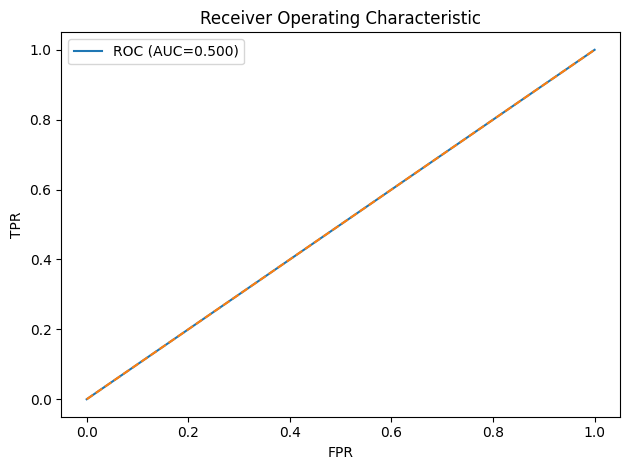

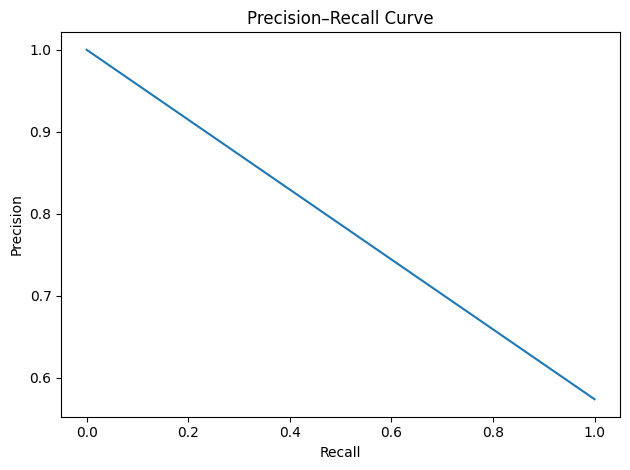

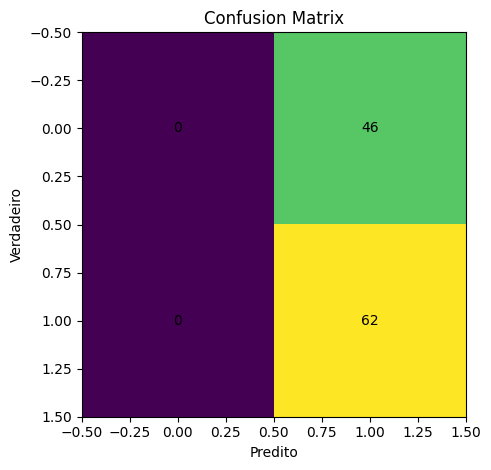

/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

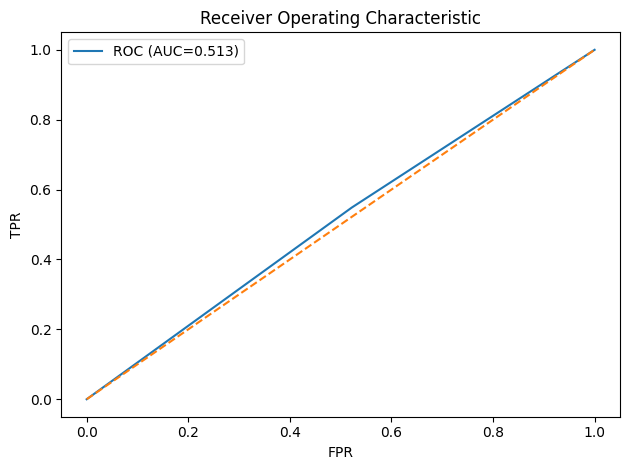

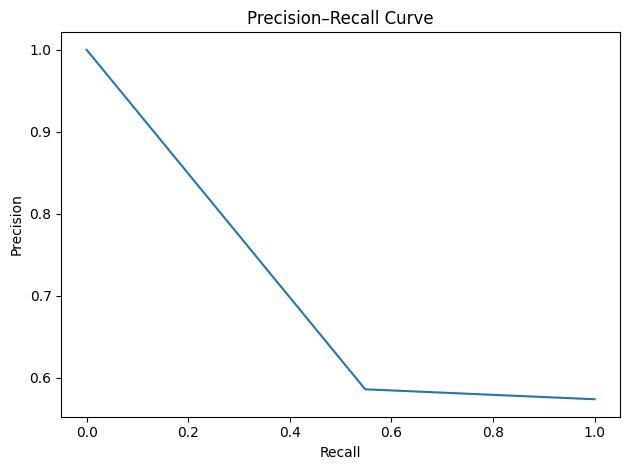

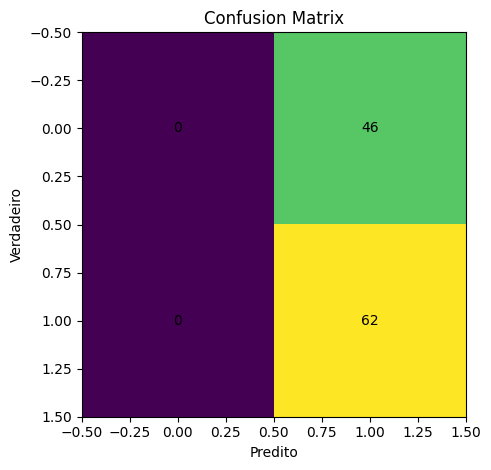

{
  "n_samples_total": 432,
  "n_features": 9,
  "n_groups": 432,
  "class_balance": {
    "pos": 238,
    "neg": 194
  },
  "dummy_reports": {
    "dummy_most_frequent": {
      "strategy": "most_frequent",
      "test_size": 108,
      "train_size": 324,
      "auc_test": 0.5,
      "precision_pos": 0.5740740740740741,
      "recall_pos": 1.0,
      "f1_pos": 0.7294117647058823,
      "threshold": 1.0,
      "plots": {
        "roc": "reports/dummy_most_frequent_test_roc.png",
        "pr": "reports/dummy_most_frequent_test_pr.png",
        "cm": "reports/dummy_most_frequent_test_cm.png"
      }
    },
    "dummy_stratified": {
      "strategy": "stratified",
      "test_size": 108,
      "train_size": 324,
      "auc_test": 0.5133239831697054,
      "precision_pos": 0.5740740740740741,
      "recall_pos": 1.0,
      "f1_pos": 0.7294117647058823,
      "threshold": 0.0,
      "plots": {
        "roc": "reports/dummy_stratified_test_roc.png",
        "pr": "reports/dummy_stratified_te

/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vini/dev/machine-learning-final-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

In [ ]:
import os, json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, roc_curve,
    confusion_matrix, classification_report
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier

os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
DATA_PATH = Path("data/sleep.csv")
REPORTS_DIR = Path("reports")
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

def load_data(path: Path) -> pd.DataFrame:
    return pd.read_csv(path)

def make_target(df: pd.DataFrame) -> pd.Series:
    return (df["Sleep efficiency"] < 0.85).astype(int)

def _circ(ts):
    if pd.isna(ts): return np.nan, np.nan
    rad = (ts.hour + ts.minute/60.0)/24.0 * 2*np.pi
    return np.cos(rad), np.sin(rad)

def engineer(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    bt = pd.to_datetime(df.get("Bedtime"), errors="coerce")
    wu = pd.to_datetime(df.get("Wakeup time"), errors="coerce")
    df["bt_cos"], df["bt_sin"] = zip(*bt.apply(_circ))
    df["wu_cos"], df["wu_sin"] = zip(*wu.apply(_circ))

    base_cols = [
        "Caffeine intake","Alcohol consumption","Exercise frequency","Age"
    ]
    df = pd.get_dummies(
        df,
        columns=[c for c in ["Gender","Smoking status"] if c in df.columns],
        drop_first=True
    )
    keep = [
        "bt_cos","bt_sin","wu_cos","wu_sin",
        *base_cols,
        *[c for c in df.columns if c.startswith("Gender_") or c.startswith("Smoking status_")]
    ]
    df = df.reindex(columns=keep)
    df.columns = df.columns.str.replace(r"\s+", "_", regex=True)

    df = df.loc[:, df.notna().any()]
    const_mask = df.nunique(dropna=False) <= 1
    df = df.loc[:, ~const_mask]
    return df

def sanitize_features_targets(Xf: pd.DataFrame, y: pd.Series):
    Xf = Xf.copy()
    Xf.columns = Xf.columns.map(lambda c: str(c).strip().replace(" ", "_"))
    for col in Xf.columns:
        if not np.issubdtype(Xf[col].dtype, np.number):
            Xf[col] = pd.to_numeric(Xf[col], errors="coerce")
    Xf = Xf.loc[:, Xf.notna().any(axis=0)]
    const_mask = Xf.nunique(dropna=False) <= 1
    if const_mask.any():
        Xf = Xf.loc[:, ~const_mask]
    arr = Xf.to_numpy(dtype=float, copy=False)
    finite_mask = np.isfinite(arr).all(axis=1)
    Xf = Xf.loc[finite_mask]
    y = y.loc[Xf.index]
    Xf = Xf.dropna(axis=0)
    y = y.loc[Xf.index]
    return Xf, y

def plot_and_save_curves(y_true, prob, thr, prefix: str):
    fpr, tpr, _ = roc_curve(y_true, prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc_score(y_true, prob):.3f})')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.tight_layout()
    p1 = REPORTS_DIR/f"{prefix}_roc.png"
    plt.savefig(p1)
    plt.show()

    pr, re, _ = precision_recall_curve(y_true, prob)
    plt.figure()
    plt.plot(re, pr)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision–Recall Curve')
    plt.tight_layout()
    p2 = REPORTS_DIR/f"{prefix}_pr.png"
    plt.savefig(p2)
    plt.show()

    y_pred = (prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.tight_layout()
    p3 = REPORTS_DIR/f"{prefix}_cm.png"
    plt.savefig(p3)
    plt.show()
    return str(p1), str(p2), str(p3)

def dummy_pipeline(strategy="most_frequent", random_state=42):
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf",     DummyClassifier(strategy=strategy, random_state=random_state))
    ])


df = load_data(DATA_PATH)
y_full = make_target(df)
Xf_full = engineer(df)
Xf_full, y_full = sanitize_features_targets(Xf_full, y_full)

groups_all = df.get("Subject ID", pd.Series(np.arange(len(df), dtype=int), index=df.index))
groups_all = pd.Series(groups_all).loc[Xf_full.index]

gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=123)
train_idx, test_idx = next(gss.split(Xf_full, y_full, groups=groups_all))
X_tr, X_te = Xf_full.iloc[train_idx], Xf_full.iloc[test_idx]
y_tr, y_te = y_full.iloc[train_idx], y_full.iloc[test_idx]

reports = {}

for name, strat in [("dummy_most_frequent","most_frequent"),
                    ("dummy_stratified","stratified")]:
    pipe = dummy_pipeline(strategy=strat, random_state=123)
    pipe.fit(X_tr, y_tr)
    prob_te = pipe.predict_proba(X_te)[:,1]

    prec, rec, thr = precision_recall_curve(y_te, prob_te)
    f1s = 2*(prec*rec)/(prec+rec+1e-12)
    best_idx = int(np.nanargmax(f1s))
    best_thr = 0.5 if best_idx==len(thr) else float(thr[best_idx])

    p_roc, p_pr, p_cm = plot_and_save_curves(y_te, prob_te, best_thr, prefix=f"{name}_test")

    y_pred = (prob_te >= best_thr).astype(int)
    rep = classification_report(y_te, y_pred, output_dict=True)

    reports[name] = {
        "strategy": strat,
        "test_size": int(X_te.shape[0]),
        "train_size": int(X_tr.shape[0]),
        "auc_test": float(roc_auc_score(y_te, prob_te)),
        "precision_pos": float(rep["1"]["precision"]),
        "recall_pos": float(rep["1"]["recall"]),
        "f1_pos": float(rep["1"]["f1-score"]),
        "threshold": best_thr,
        "plots": {"roc": p_roc, "pr": p_pr, "cm": p_cm}
    }

print(json.dumps({
    "n_samples_total": int(len(y_full)),
    "n_features": int(Xf_full.shape[1]),
    "n_groups": int(pd.Series(groups_all).nunique()),
    "class_balance": {
        "pos": int(y_full.sum()),
        "neg": int((1 - y_full).sum())
    },
    "dummy_reports": reports
}, indent=2))
